In [1]:
#imports
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
base_path = r"../Dataset/MRI Images"
categories = ["AD", "CN"]

In [4]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

# Create DataFrame
df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})


In [5]:
df.head()

,image_path,label
0,../Dataset/MRI Images\AD\AD_0001.jpg,AD
1,../Dataset/MRI Images\AD\AD_0002.jpg,AD
2,../Dataset/MRI Images\AD\AD_0003.jpg,AD
3,../Dataset/MRI Images\AD\AD_0004.jpg,AD
4,../Dataset/MRI Images\AD\AD_0005.jpg,AD


In [6]:
df.shape

(6805, 2)

In [7]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6805 entries, 0 to 6804
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6805 non-null   object
 1   label       6805 non-null   object
dtypes: object(2)
memory usage: 106.5+ KB


In [11]:
df.describe()

,image_path,label
count,6805,6805
unique,6805,2
top,../Dataset/MRI Images\CN\CN_3166.jpg,AD
freq,1,3639


In [12]:
df['label'].unique()

array(['AD', 'CN'], dtype=object)

In [13]:
df['label'].value_counts()

label
AD    3639
CN    3166
Name: count, dtype: int64

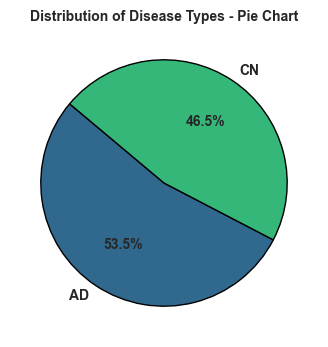

In [14]:
sns.set_style("whitegrid")

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(4, 4))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
       startangle=140, colors=colors, textprops={'fontsize': 10, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Disease Types - Pie Chart", fontsize=10, fontweight='bold')

plt.show()

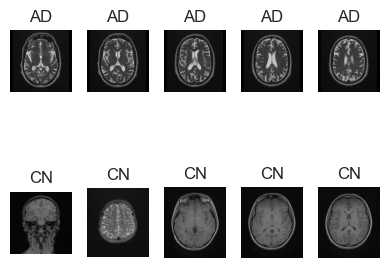

In [15]:
num_images = 5
plt.figure(figsize=(4, 4))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]
    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [16]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [17]:
df = df[['image_path', 'category_encoded']]

In [18]:
min_samples = df['category_encoded'].value_counts().min()
balanced_df = df.groupby('category_encoded').sample(n=min_samples, random_state=42)
balanced_df = balanced_df.reset_index(drop=True)
balanced_df = balanced_df[['image_path', 'category_encoded']]
print(balanced_df)

                                image_path  category_encoded
0     ../Dataset/MRI Images\AD\AD_0416.jpg                 0
1     ../Dataset/MRI Images\AD\AD_1079.jpg                 0
2     ../Dataset/MRI Images\AD\AD_1840.jpg                 0
3     ../Dataset/MRI Images\AD\AD_0299.jpg                 0
4     ../Dataset/MRI Images\AD\AD_2955.jpg                 0
...                                    ...               ...
6327  ../Dataset/MRI Images\CN\CN_0633.jpg                 1
6328  ../Dataset/MRI Images\CN\CN_0668.jpg                 1
6329  ../Dataset/MRI Images\CN\CN_1181.jpg                 1
6330  ../Dataset/MRI Images\CN\CN_1856.jpg                 1
6331  ../Dataset/MRI Images\CN\CN_0889.jpg                 1

[6332 rows x 2 columns]


In [19]:
df_resampled = balanced_df

In [20]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [21]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded'] 
)

Load and Preprocess Images

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    batch_size=1,
    shuffle=False
)


Found 5065 validated image filenames belonging to 2 classes.
Found 633 validated image filenames belonging to 2 classes.
Found 634 validated image filenames belonging to 2 classes.


Simple CNN

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_simple_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [28]:
simple_cnn = create_simple_cnn()
history_cnn = simple_cnn.fit(train_gen, validation_data=valid_gen, epochs=5)

Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.6613 - loss: 0.6052 - val_accuracy: 0.8736 - val_loss: 0.2692
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 116s 730ms/step - accuracy: 0.8985 - loss: 0.2096 - val_accuracy: 0.9068 - val_loss: 0.1692
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 120s 756ms/step - accuracy: 0.9461 - loss: 0.1301 - val_accuracy: 0.9431 - val_loss: 0.1133
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 101s 636ms/step - accuracy: 0.9698 - loss: 0.0861 - val_accuracy: 0.9605 - val_loss: 0.0878
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 107s 669ms/step - accuracy: 0.9889 - loss: 0.0382 - val_accuracy: 0.9731 - val_loss: 0.0775


Load and Customize Models (VGG16, ResNet50)

In [23]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model_class, input_shape=(224, 224, 3)):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Transfer learning, freeze base
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


Hybrid Models : VGG-with-SVM-GNB-XGBoost

In [32]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Parameters
img_size = (224, 224)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features
def extract_features(image_paths):
    features = []
    for path in tqdm(image_paths):
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        feature = vgg_model.predict(img_array, verbose=0)
        features.append(feature.flatten())  # flatten for ML models
    return np.array(features)


In [33]:
# You already have these DataFrames
X_train_paths = train_df_new['image_path'].tolist()
X_valid_paths = valid_df_new['image_path'].tolist()
X_test_paths = test_df_new['image_path'].tolist()

# Labels
y_train = train_df_new['category_encoded'].astype(int).values
y_valid = valid_df_new['category_encoded'].astype(int).values
y_test = test_df_new['category_encoded'].astype(int).values

# Feature extraction
X_train_feats = extract_features(X_train_paths)
X_valid_feats = extract_features(X_valid_paths)
X_test_feats  = extract_features(X_test_paths)


100%|██████████| 634/634 [03:24<00:00,  3.10it/s]


Train Models

In [24]:
vgg_model = build_model(VGG16)
resnet_model = build_model(ResNet50)

history_vgg = vgg_model.fit(train_gen, validation_data=valid_gen, epochs=5)
history_resnet = resnet_model.fit(train_gen, validation_data=valid_gen, epochs=5)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 841s 5s/step - accuracy: 0.4887 - loss: 0.7492 - val_accuracy: 0.5118 - val_loss: 0.6881
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1133s 7s/step - accuracy: 0.5348 - loss: 0.7032 - val_accuracy: 0.6098 - val_loss: 0.6770
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1148s 7s/step - accuracy: 0.5288 - loss: 0.6947 - val_accuracy: 0.6667 - val_loss: 0.6675
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 1081s 7s/step - accuracy: 0.5697 - loss: 0.6845 - val_accuracy: 0.6919 - val_loss: 0.6588
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 885s 6s/step - accuracy: 0.5820 - loss: 0.6732 - val_accuracy: 0.6809 - val_loss: 0.6508
Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.4896 - loss: 0.7716 - val_accuracy: 0.6840 - val_loss: 0.6568
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.5532 - loss: 0.7151 - val_accuracy: 0.7046 - val_loss: 0.62

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_feats, y_train)

In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_feats, y_train)


In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()
gnb_model.fit(X_train_feats, y_train)


Evaluate models with Classification Report & Confusion Matrix

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_gen, model_name="Model"):
    preds = model.predict(test_gen)
    y_pred = (preds > 0.5).astype("int32").flatten()
    y_true = test_gen.classes

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=['AD', 'CN']))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'CN'], yticklabels=['AD', 'CN'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


634/634 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step

Classification Report for Simple CNN:
              precision    recall  f1-score   support

          AD       0.99      0.96      0.97       317
          CN       0.96      0.99      0.97       317

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634



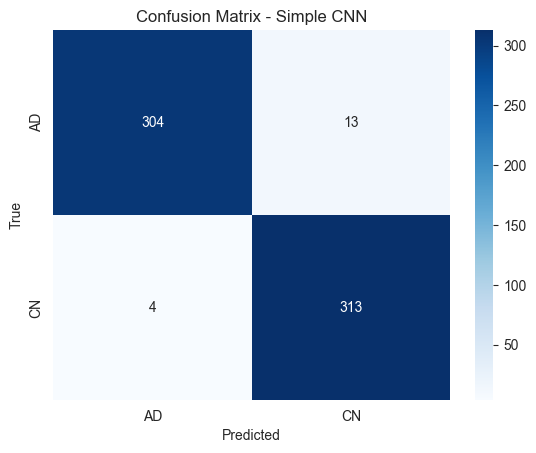

In [29]:
evaluate_model(simple_cnn, test_gen, "Simple CNN")

634/634 ━━━━━━━━━━━━━━━━━━━━ 148s 233ms/step

Classification Report for VGG16:
              precision    recall  f1-score   support

          AD       0.66      0.89      0.76       317
          CN       0.83      0.53      0.65       317

    accuracy                           0.71       634
   macro avg       0.74      0.71      0.70       634
weighted avg       0.74      0.71      0.70       634



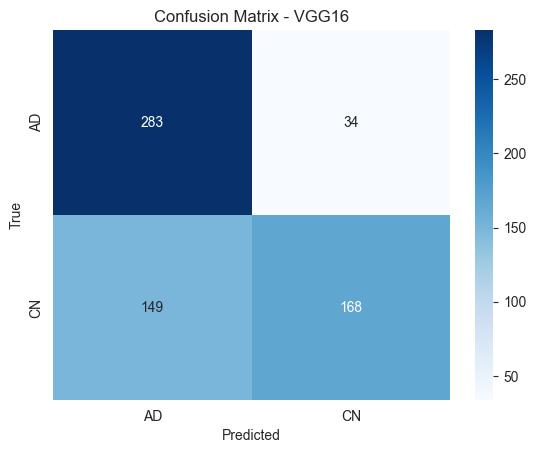

634/634 ━━━━━━━━━━━━━━━━━━━━ 84s 130ms/step

Classification Report for ResNet50:
              precision    recall  f1-score   support

          AD       0.73      0.73      0.73       317
          CN       0.73      0.73      0.73       317

    accuracy                           0.73       634
   macro avg       0.73      0.73      0.73       634
weighted avg       0.73      0.73      0.73       634



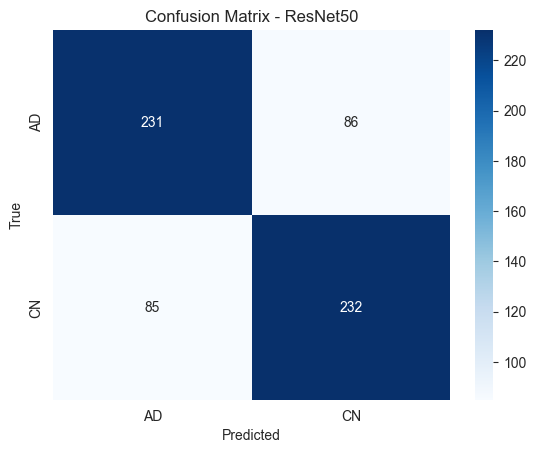

In [26]:
evaluate_model(vgg_model, test_gen, "VGG16")
evaluate_model(resnet_model, test_gen, "ResNet50")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_ml_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['AD', 'CN']))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'CN'], yticklabels=['AD', 'CN'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
evaluate_ml_model(svm_model, X_test_feats, y_test, "VGG16 + SVM")
evaluate_ml_model(xgb_model, X_test_feats, y_test, "VGG16 + XGBoost")
evaluate_ml_model(gnb_model, X_test_feats, y_test, "VGG16 + GNB")


In [47]:

from tensorflow.keras import layers, models
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

class ContinuousLayer(layers.Layer):
    def __init__(self, kernel_size=5, num_basis=10, output_channels=16, **kwargs):
        super(ContinuousLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.num_basis = num_basis
        self.output_channels = output_channels
        self.centers = self.add_weight(
            name='centers',
            shape=(num_basis, 2),
            initializer='random_normal',
            trainable=True
        )
        self.widths = self.add_weight(
            name='widths',
            shape=(num_basis,),
            initializer='ones',
            trainable=True,
            constraint=tf.keras.constraints.NonNeg()
        )
        self.kernel_weights = self.add_weight(
            name='kernel_weights',
            shape=(kernel_size, kernel_size, channels, output_channels),
            initializer='glorot_normal',
            trainable=True
        )

    def call(self, inputs):
        height, width = img_size
        x = tf.range(0, height, 1.0)
        y = tf.range(0, width, 1.0)
        x_grid, y_grid = tf.meshgrid(x, y)
        grid = tf.stack([x_grid, y_grid], axis=-1)  

        basis = []
        for i in range(self.num_basis):
            center = self.centers[i]
            width = self.widths[i]
            dist = tf.reduce_sum(((grid - center) / width) ** 2, axis=-1)
            basis_i = tf.exp(-dist)  
            basis.append(basis_i)
        basis = tf.stack(basis, axis=-1)  

        basis_weights = tf.reduce_mean(basis, axis=[0, 1]) 
        basis_weights = tf.nn.softmax(basis_weights) 
        basis_weights = basis_weights[:, tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]  

        modulated_kernel = self.kernel_weights * tf.reduce_sum(basis_weights, axis=0)  

        output = tf.nn.conv2d(
            inputs,
            modulated_kernel,
            strides=[1, 1, 1, 1],
            padding='SAME'
        )  

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.output_channels)

    def smoothness_penalty(self):
        grad_x = tf.reduce_mean(tf.square(self.kernel_weights[1:, :, :, :] - self.kernel_weights[:-1, :, :, :]))
        grad_y = tf.reduce_mean(tf.square(self.kernel_weights[:, 1:, :, :] - self.kernel_weights[:, :-1, :, :]))
        return grad_x + grad_y

class VariationalLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda1=0.01, lambda2=1.0):
        super(VariationalLoss, self).__init__()
        self.model = model  
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.bce = tf.keras.losses.BinaryCrossentropy()

    def call(self, y_true, y_pred):
        smoothness_penalty = 0
        for layer in self.model.layers:
            if isinstance(layer, ContinuousLayer):
                smoothness_penalty += layer.smoothness_penalty()
        prediction_loss = self.bce(y_true, y_pred)
        return self.lambda2 * prediction_loss + self.lambda1 * smoothness_penalty

def build_continuous_model():
    inputs = layers.Input(shape=img_shape)
    x = ContinuousLayer(kernel_size=5, num_basis=10, output_channels=16)(inputs)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

model = build_continuous_model()

model.compile(
    optimizer='adam',
    loss=VariationalLoss(model=model, lambda1=0.01, lambda2=1.0),
    metrics=['accuracy']
)

history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=3,
    verbose=1
)

Found 5065 validated image filenames belonging to 2 classes.
Found 633 validated image filenames belonging to 2 classes.
Found 634 validated image filenames belonging to 2 classes.
Epoch 1/3
317/317 ━━━━━━━━━━━━━━━━━━━━ 113s 352ms/step - accuracy: 0.7421 - loss: 0.7118 - val_accuracy: 0.9400 - val_loss: 0.1765
Epoch 2/3
317/317 ━━━━━━━━━━━━━━━━━━━━ 52s 164ms/step - accuracy: 0.9552 - loss: 0.1227 - val_accuracy: 0.9684 - val_loss: 0.0821
Epoch 3/3
317/317 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - accuracy: 0.9788 - loss: 0.0593 - val_accuracy: 0.9747 - val_loss: 0.0748


In [48]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ continuous_layer                │ (None, 224, 224, 16)   │         1,230 │
│ (ContinuousLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,074,799 (294.02 MB)

 Trainable params: 25,691,599 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,383,200 (196.01 MB)

In [49]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9801 - loss: 0.0874
Test Loss: 0.0763, Test Accuracy: 0.9811


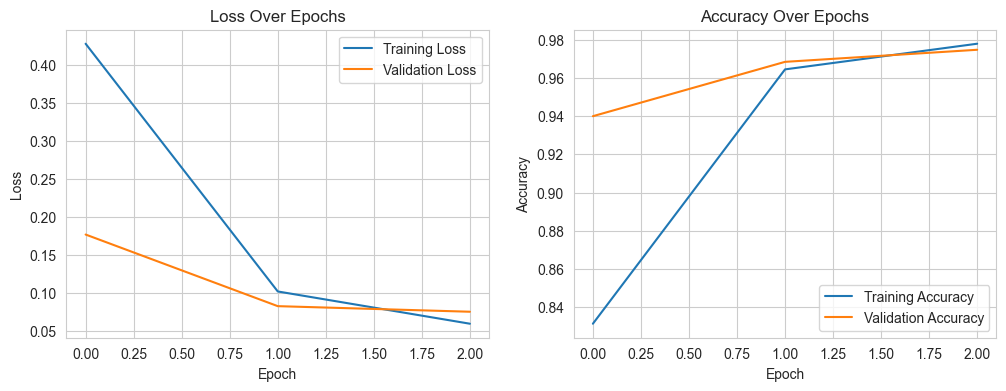

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(test_gen_new)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_gen_new.classes
cm = confusion_matrix(y_true, y_pred_binary).ravel()  
print("Confusion Matrix (TN, FP, FN, TP):", cm)

class_names = list(test_gen_new.class_indices.keys())  
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=class_names))

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Confusion Matrix (TN, FP, FN, TP): [308   9   3 314]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       317
           1       0.97      0.99      0.98       317

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



In [52]:
model.save('model.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('model.h5')
